In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/manojmanivannan/machine-learning-with-PyTorch/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
    IS_COLAB = True
except ModuleNotFoundError:
    IS_COLAB = False
    pass

from config import *
import_from_github(dataset=1)

In [2]:
from prediction_models.genericRegressionClassification import *
from plots.stage1 import *
import pandas as pd
from explore.analytics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from feature_engine.creation import CyclicalFeatures, MathFeatures
from feature_engine.outliers import Winsorizer

# read the dataset using pandas

dataset_path = 'dataset/power_plant/pp_data.csv'
dataset_path_actual = '../'+dataset_path if not IS_COLAB else dataset_path
df = pd.read_csv(dataset_path_actual, sep=',', header=0)

In [3]:
#Check to see if there are missing data
print(df.isnull().sum())

# Features consist of hourly average ambient variables
# - Temperature (AT) in the range 1.81°C and 37.11°C,
# - Ambient Pressure (AP) in the range 992.89-1033.30 millibar,
# - Relative Humidity (RH) in the range 25.56% to 100.16%
# - Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
# - Net hourly electrical energy output (PE) 420.26-495.76 MW
# The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.
df.head()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


Stats for Temperature
--------------------
Minimum:1.81
Mean:19.65
Median:20.34
Mode:25.21
Maximum:37.11

Stats for Vacuum
--------------------
Minimum:25.36
Mean:54.31
Median:52.08
Mode:41.17
Maximum:81.56

Stats for Pressure
--------------------
Minimum:992.89
Mean:1013.26
Median:1012.94
Mode:1013.88
Maximum:1033.30

Stats for Relative Humidity
--------------------
Minimum:25.56
Mean:73.31
Median:74.97
Mode:100.09
Maximum:100.16

Stats for Energy output
--------------------
Minimum:420.26
Mean:454.37
Median:451.55
Mode:468.80
Maximum:495.76



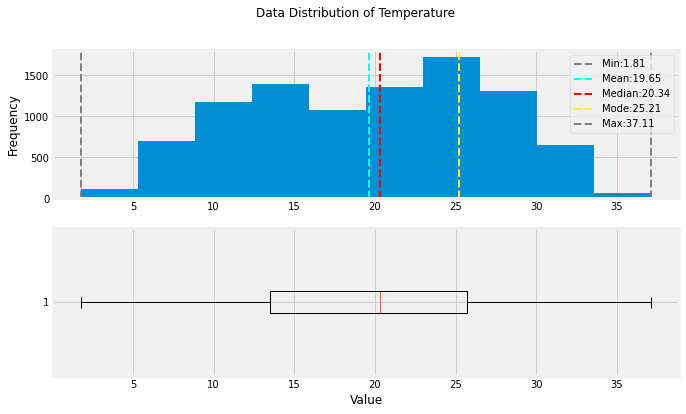

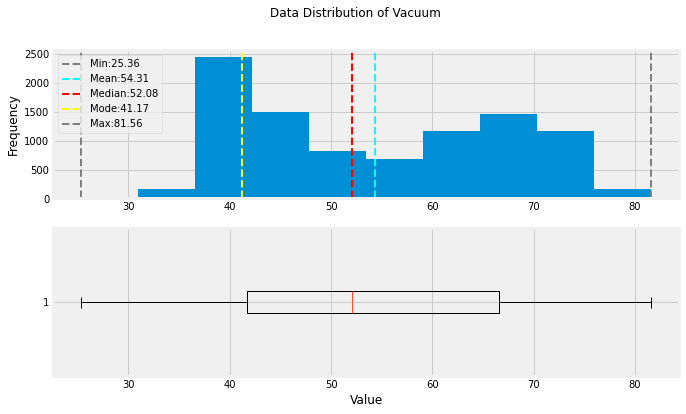

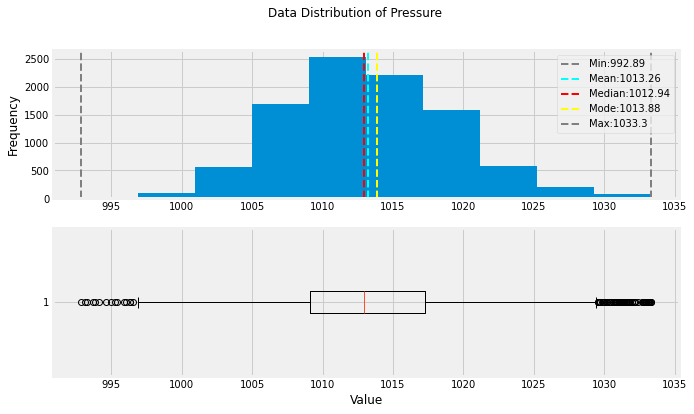

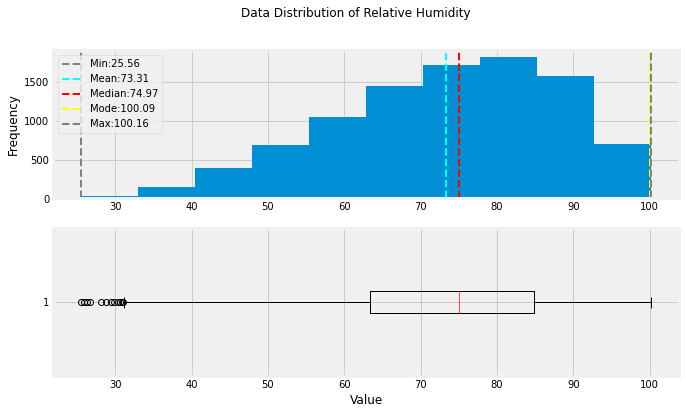

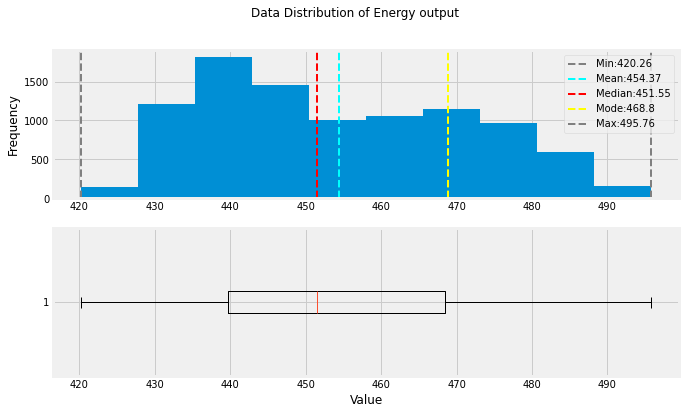

In [4]:
show_distribution(df.AT,'Temperature')
show_distribution(df.V, 'Vacuum')
show_distribution(df.AP, 'Pressure')
show_distribution(df.RH, 'Relative Humidity')
show_distribution(df.PE, 'Energy output')

Seems there are outliers present for AP (Pressure) and RH (Relative Humidity)
lets clean up those data

In [5]:
outlier_trimmer = Winsorizer(capping_method='gaussian', tail='both',fold=2)

In [6]:
df['AP'] = outlier_trimmer.fit_transform(df[['AP']]).AP
df['RH'] = outlier_trimmer.fit_transform(df[['RH']]).RH


array([[<AxesSubplot:title={'center':'AT'}>,
        <AxesSubplot:title={'center':'V'}>],
       [<AxesSubplot:title={'center':'AP'}>,
        <AxesSubplot:title={'center':'RH'}>],
       [<AxesSubplot:title={'center':'PE'}>, <AxesSubplot:>]],
      dtype=object)

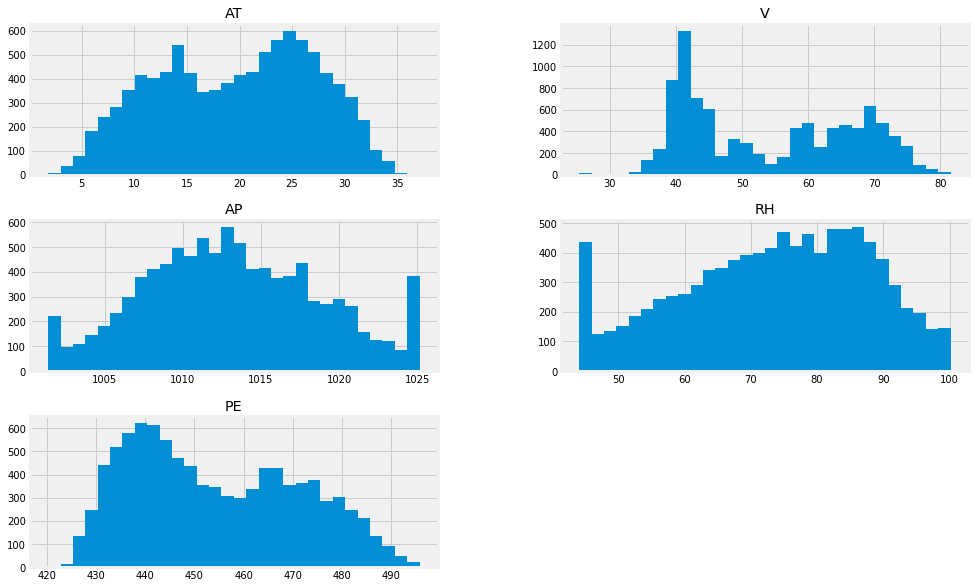

In [7]:
df.hist(bins=30,figsize=(15, 10))

In [8]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.204298,73.470712,454.365009
std,7.452473,12.707893,5.668872,14.228470,17.066995
min,1.810000,25.360000,1001.381511,44.108440,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1025.136646,100.160000,495.760000


In [9]:
# Dropping duplicated records
df = df.drop_duplicates(keep=False)

array([[<AxesSubplot:title={'center':'AT'}>,
        <AxesSubplot:title={'center':'V'}>],
       [<AxesSubplot:title={'center':'AP'}>,
        <AxesSubplot:title={'center':'RH'}>],
       [<AxesSubplot:title={'center':'PE'}>, <AxesSubplot:>]],
      dtype=object)

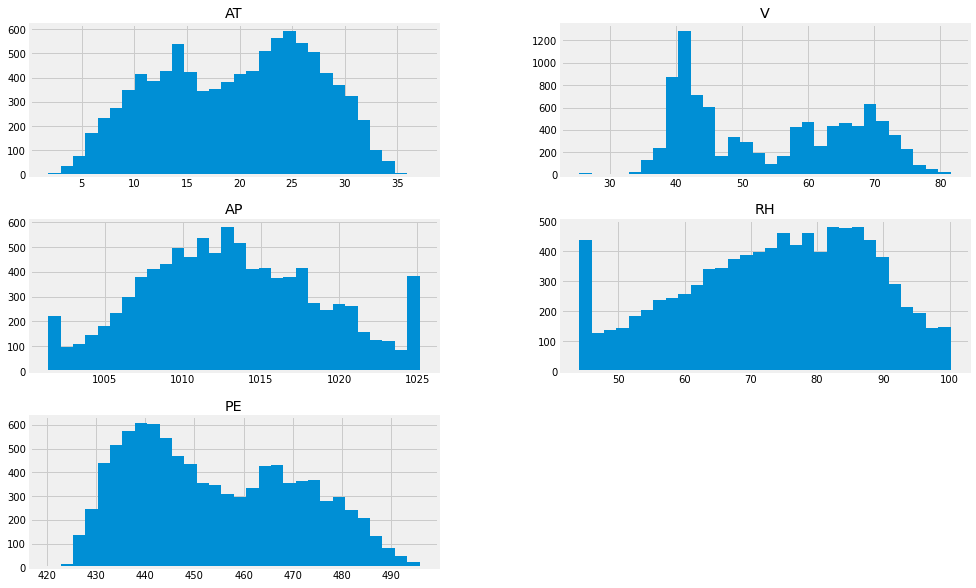

In [10]:
df.hist(bins=30,figsize=(15, 10))

#### Histogram inference
Looking at the histograms we draw some inferences
##### Ambient Temperature (AT)
The ambient temperature histogram is bimodal distribution. In reality it is actually two unimodal (one-peaked) distributions.
since the dataset contains data points across a year ( in fact: 6 years (2006-2011)), that peaks reference to temperature swings 
between the summer and winter.
##### Ambient Pressure (AP)
The ambient pressure histogram shows us that the pressure is greatly remained around a mean of 1013 millibars
##### Relative Humidity
The RH is right shifted, showing that is a more humid location where is power plant is located

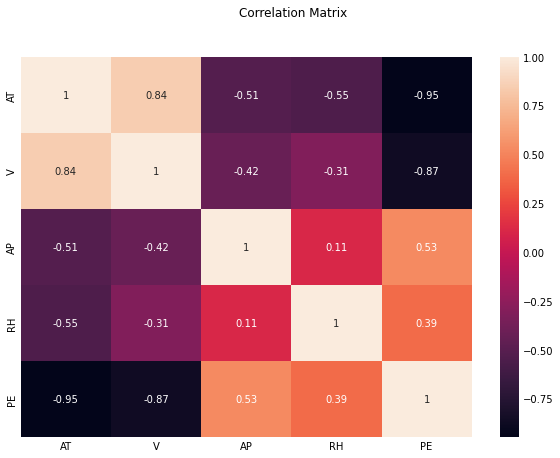

,AT,V,AP,RH,PE
AT,1.000000,0.843268,-0.514937,-0.546322,-0.947685
V,0.843268,1.000000,-0.423609,-0.313799,-0.870029
AP,-0.514937,-0.423609,1.000000,0.107093,0.526184
RH,-0.546322,-0.313799,0.107093,1.000000,0.393830
PE,-0.947685,-0.870029,0.526184,0.393830,1.000000


In [11]:
correlation_matrix(df,plot=True)

It appears that there are several strong correlations. The Energy produced (PE) is strongly correlated with ambient temperature (AT) and exhaust vacuum (V)
Let's look at them visually

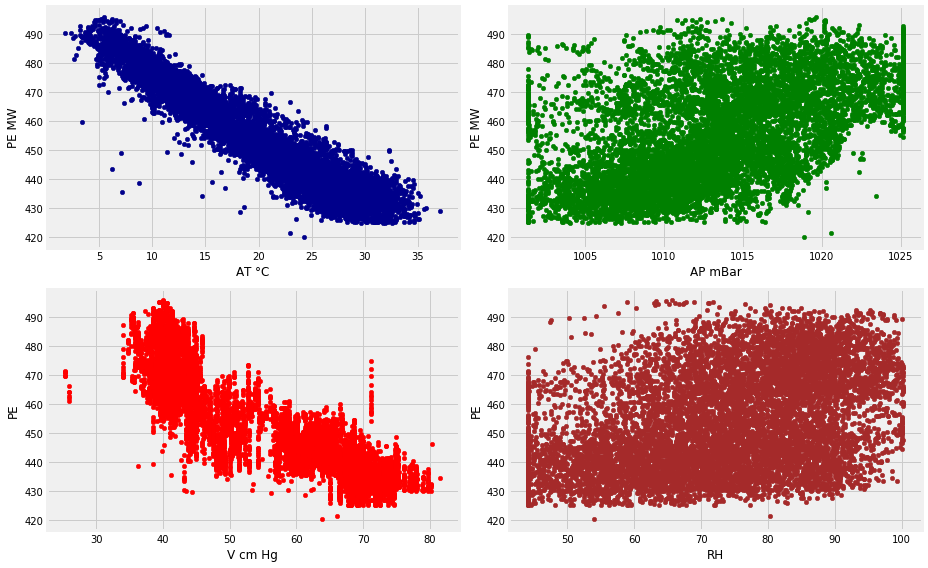

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(13,8))

df.plot.scatter(x='AT', y='PE', c='DarkBlue', ax=axes[0,0]); axes[0,0].set_xlabel(r'AT $\degree$C'); axes[0,0].set_ylabel('PE MW')
df.plot.scatter(x='AP', y='PE', c='green', ax=axes[0,1]); axes[0,1].set_xlabel(r'AP mBar'); axes[0,1].set_ylabel('PE MW');
df.plot.scatter(x='V', y='PE', c='red', ax=axes[1,0]); axes[1,0].set_xlabel(r'V cm Hg'); axes[0,1].set_ylabel('PE MW');
df.plot.scatter(x='RH', y='PE', c='brown', ax=axes[1,1]) ; axes[1,1].set_xlabel(r'RH'); axes[0,1].set_ylabel('PE MW');
fig.tight_layout()

In [13]:
sf_tansformer = CyclicalFeatures()
df_cf = sf_tansformer.fit_transform(df[['AT','V','AP','RH']])

In [14]:
df = pd.concat([df,df_cf.filter([c for c in df_cf.columns if '_' in c])],axis=1)

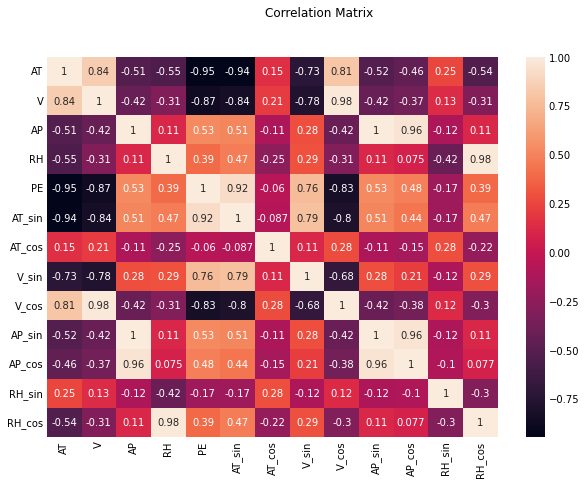

,AT,V,AP,RH,PE,AT_sin,AT_cos,V_sin,V_cos,AP_sin,AP_cos,RH_sin,RH_cos
AT,1.000000,0.843268,-0.514937,-0.546322,-0.947685,-0.942286,0.153215,-0.734646,0.806996,-0.515146,-0.458714,0.251005,-0.536067
V,0.843268,1.000000,-0.423609,-0.313799,-0.870029,-0.839726,0.205165,-0.777014,0.981371,-0.423802,-0.374390,0.128971,-0.308886
AP,-0.514937,-0.423609,1.000000,0.107093,0.526184,0.506562,-0.112624,0.281301,-0.420937,0.999999,0.959012,-0.117691,0.106377
RH,-0.546322,-0.313799,0.107093,1.000000,0.393830,0.473284,-0.248878,0.293040,-0.306360,0.107232,0.075301,-0.418725,0.977238
PE,-0.947685,-0.870029,0.526184,0.393830,1.000000,0.922186,-0.060378,0.761753,-0.832992,0.526357,0.477003,-0.171784,0.389772
AT_sin,-0.942286,-0.839726,0.506562,0.473284,0.922186,1.000000,-0.087445,0.786379,-0.797991,0.506820,0.441555,-0.173395,0.474072
AT_cos,0.153215,0.205165,-0.112624,-0.248878,-0.060378,-0.087445,1.000000,0.106257,0.275366,-0.112445,-0.147426,0.280662,-0.223004
V_sin,-0.734646,-0.777014,0.281301,0.293040,0.761753,0.786379,0.106257,1.000000,-0.681984,0.281607,0.213186,-0.116077,0.291340
V_cos,0.806996,0.981371,-0.420937,-0.306360,-0.832992,-0.797991,0.275366,-0.681984,1.000000,-0.421105,-0.376858,0.124320,-0.301585
AP_sin,-0.515146,-0.423802,0.999999,0.107232,0.526357,0.506820,-0.112445,0.281607,-0.421105,1.000000,0.958588,-0.117745,0.106503


In [15]:
correlation_matrix(df,plot=True)

Using 5 components, we can explain 95.51% of the variability in the original data.


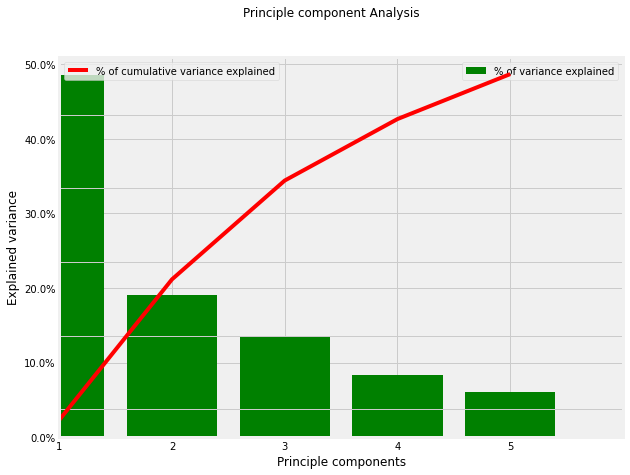

In [16]:
pca,n_components = get_principle_component(df.drop('PE',axis=1),least_components=1,least_explained_variance=0.90,plot=True)
pca_df = pd.DataFrame(pca.fit_transform(df.drop('PE',axis=1)),columns=[f'PC-{i}' for i in range(1,n_components+1)])
choosen_columns = pca_df.columns

In [17]:
pca = PCA(n_components=1)
pca.fit(np.array(df[['V','AT','V_cos']]))
print("variance explained : ",pca.explained_variance_ratio_)

# y = pca.transform(np.array(df[['V','AT','V_cos']]))
# new_component = pd.DataFrame(y)
# new_component = new_component.rename(columns={0: 'new_component'})
# df["new_component"] = new_component
# df.drop(['V','AT','V_cos'], axis=1, inplace=True)

variance explained :  [0.94148793]


In [18]:
df = df.dropna(axis=0)

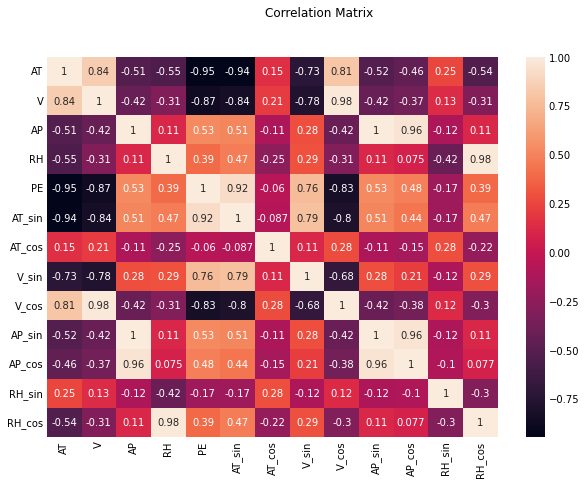

,AT,V,AP,RH,PE,AT_sin,AT_cos,V_sin,V_cos,AP_sin,AP_cos,RH_sin,RH_cos
AT,1.000000,0.843268,-0.514937,-0.546322,-0.947685,-0.942286,0.153215,-0.734646,0.806996,-0.515146,-0.458714,0.251005,-0.536067
V,0.843268,1.000000,-0.423609,-0.313799,-0.870029,-0.839726,0.205165,-0.777014,0.981371,-0.423802,-0.374390,0.128971,-0.308886
AP,-0.514937,-0.423609,1.000000,0.107093,0.526184,0.506562,-0.112624,0.281301,-0.420937,0.999999,0.959012,-0.117691,0.106377
RH,-0.546322,-0.313799,0.107093,1.000000,0.393830,0.473284,-0.248878,0.293040,-0.306360,0.107232,0.075301,-0.418725,0.977238
PE,-0.947685,-0.870029,0.526184,0.393830,1.000000,0.922186,-0.060378,0.761753,-0.832992,0.526357,0.477003,-0.171784,0.389772
AT_sin,-0.942286,-0.839726,0.506562,0.473284,0.922186,1.000000,-0.087445,0.786379,-0.797991,0.506820,0.441555,-0.173395,0.474072
AT_cos,0.153215,0.205165,-0.112624,-0.248878,-0.060378,-0.087445,1.000000,0.106257,0.275366,-0.112445,-0.147426,0.280662,-0.223004
V_sin,-0.734646,-0.777014,0.281301,0.293040,0.761753,0.786379,0.106257,1.000000,-0.681984,0.281607,0.213186,-0.116077,0.291340
V_cos,0.806996,0.981371,-0.420937,-0.306360,-0.832992,-0.797991,0.275366,-0.681984,1.000000,-0.421105,-0.376858,0.124320,-0.301585
AP_sin,-0.515146,-0.423802,0.999999,0.107232,0.526357,0.506820,-0.112445,0.281607,-0.421105,1.000000,0.958588,-0.117745,0.106503


In [19]:
correlation_matrix(df,plot=True)

In [20]:
df_feature = df.drop(['PE'],axis=1)
df_target = df['PE']

At this point, the pca_df, which is a principle components data, can be used as the feature. but for now, I will go with the original features + the new_component

In [21]:
X_train,X_val,y_train,y_val = train_test_split(df_feature,df_target,test_size=0.2, random_state=13)
# X_train,X_val,y_train,y_val = train_test_split(pca_df,df_target,test_size=0.2, random_state=13)

sc_feature = StandardScaler()
sc_feature.fit(X_train)
X_train = sc_feature.transform(X_train)
X_val = sc_feature.transform(X_val)

# sc_target = StandardScaler()
# sc_target.fit(y_train.values.reshape(-1,1))
# y_train = sc_target.transform(y_train.values.reshape(-1,1))
# y_val = sc_target.transform(y_val.values.reshape(-1,1))

y_train = y_train.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)


In [22]:
# fig = figure1(X_train, y_train, X_val, y_val); plt.show() # works only for if there is one feature

In [23]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=100)

In [24]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.02

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential()
model.add_module('linear1',nn.Linear(df_feature.shape[1], 1))
# model.add_module('linear1', nn.Linear(3, 1))


# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')
print(model.state_dict())

OrderedDict([('linear1.weight', tensor([[ 0.2207,  0.2396, -0.0676,  0.2652, -0.0632,  0.0583, -0.1405,  0.1695,
          0.2545, -0.2118,  0.2509,  0.0540]])), ('linear1.bias', tensor([0.2133]))])


In [25]:
# Clear the tensorboard logs directory
import shutil
try:
    shutil.rmtree('runs')
except FileNotFoundError:
    pass

In [26]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('powerplant')
sbs.train(n_epochs=200)

print(model.state_dict())

OrderedDict([('linear1.weight', tensor([[-12.3794,  -0.9629,  -0.9936,  -1.8894,   1.7145,   1.4983,   0.3520,
          -2.2056,  -0.6877,   2.1631,  -0.2273,   0.0755]], device='cuda:0')), ('linear1.bias', tensor([454.2863], device='cuda:0'))])


In [27]:
%load_ext tensorboard
%tensorboard --port 7000 --logdir runs

In [28]:
# Evalute the model on the training set
y_train_predictions = sbs.predict(x_train_tensor)
y_train_actual = y_train_tensor.detach().cpu().numpy()
train_mse = mean_squared_error(y_train_predictions,y_train_actual)

y_val_predictions = sbs.predict(x_val_tensor)
y_val_actual = y_val_tensor.detach().cpu().numpy()
val_mse = mean_squared_error(y_val_predictions,y_val_actual)

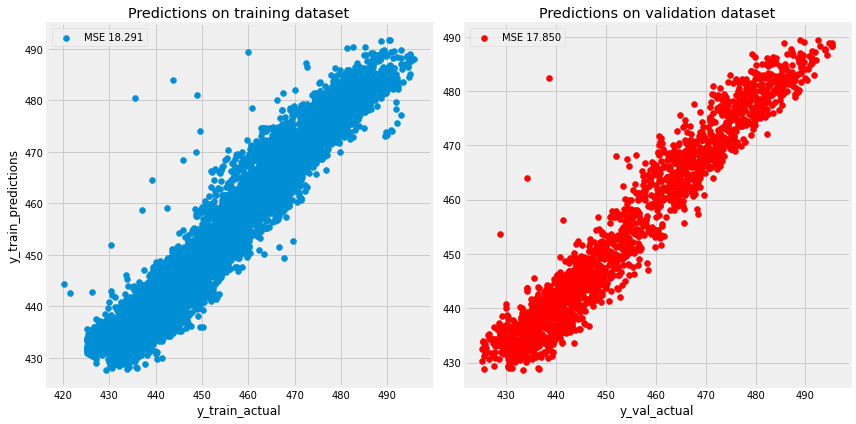

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(y_train_actual,y_train_predictions)
ax[0].set_xlabel('y_train_actual')
ax[0].set_ylabel('y_train_predictions')

ax[0].set_title('Predictions on training dataset')
ax[0].legend([f'MSE {mean_squared_error(y_train_predictions,y_train_actual):.3f}'])

ax[1].scatter(y_val_actual,y_val_predictions, c='r')
ax[1].set_xlabel('y_val_actual')
# ax[1].set_ylabel('y_val_predictions')

ax[1].set_title('Predictions on validation dataset')
ax[1].legend([f'MSE {mean_squared_error(y_val_predictions,y_val_actual):.3f}'])
fig.tight_layout()